In [181]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

In [2]:
img_arr = img.imread('input.jpg')
print(img_arr.shape)

(4032, 3024, 3)


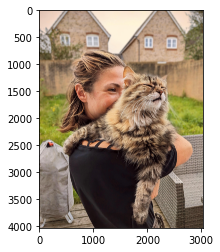

In [3]:
plt.imshow(img_arr)

In [4]:
(h,w,c) = img_arr.shape
img2D = img_arr.reshape(h*w,c)

In [5]:
%matplotlib notebook

/home/chico/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


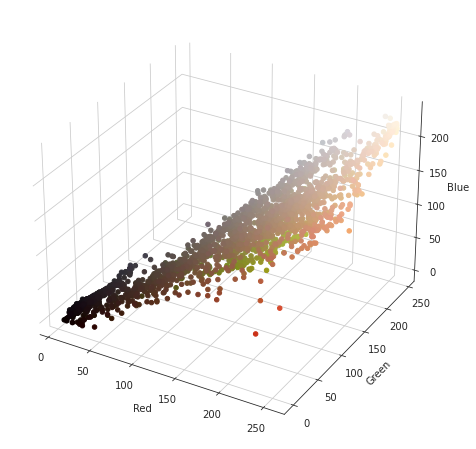

In [5]:
import seaborn as sns
sns.set_style('ticks')

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

n_samples = 2000

idxs = np.random.choice(range(len(img2D)), n_samples)

x = img2D[idxs,0]
y = img2D[idxs,1]
z = img2D[idxs,2]

colours = img2D[idxs]/255
size    = [20]*len(colours)

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.scatter(x, y, z, marker='o', c=colours, s=size, alpha=1)

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

plt.show()

__________________

In [29]:
n_colours = 25

______________

In [30]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=n_colours)
cluster_labels = kmeans_model.fit_predict(img2D)

/home/chico/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f48716269d0>
Traceback (most recent call last):
  File "/home/chico/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/chico/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/chico/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/chico/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_versi

In [ ]:
from collections import Counter
labels_count = Counter(cluster_labels)

rgb_cols = kmeans_model.cluster_centers_.round(0).astype(int)

img_quant = np.reshape(rgb_cols[cluster_labels],(h,w,c))

In [ ]:
# Save the output image

from PIL import Image

PIL_image = Image.fromarray(img_quant.astype('uint8'), 'RGB')

PIL_image.save('quantised.png')

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,10))

ax[0].imshow(img_arr)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(img_quant)
ax[1].set_title('Color Quantized Image')
ax[1].axis('off')
plt.show()

_________________

Now read the centroid list:

In [16]:
infile = 'centroids_output.txt'

triples = []
with open(infile) as f:
    for line in f:
        s = line.split()
        patch = int(s[1])
        cx    = int(s[-2][1:-1])
        cy    = int(s[-1][:-1])
        triple = (patch, cx, cy)
        triples.append(triple)
        
centroid_index_and_coordinates = np.array(triples)

In [17]:
centroid_index_and_coordinates.shape

(576870, 3)

In [18]:
from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=2)
cluster_labels = clusterer.fit_predict(centroid_index_and_coordinates[:,1:])

In [148]:
np.savetxt('centroids_output.csv', centroid_index_and_coordinates[:,1:], fmt='%d', delimiter=',')

In [147]:
with open('hdbscan_labels.txt', 'w') as f:
    s = ' '.join(str(i) for i in cluster_labels)
    f.write(s)

In [44]:
#import h5py

#with h5py.File('cluster_labels.h5', 'w') as hf:
#    hf.create_dataset('cluster_labels', data=cluster_labels, compression="gzip", compression_opts=9)
    

#with h5py.File('cluster_labels.h5', 'r') as hf:
#    cluster_labels = hf['cluster_labels'][()]

Then, take patches whose centroids are in the same cluster, and paint them all with the same number: the majority colour within the pixels in the patches in that cluster.

As for patches whose centroid doesn't belong in any cluster (i.e. is in HDBSCAN's -1 cluster for outliers), merge them into the majority colour of the pixels around them.

Save the final result as a new .png image.

I did this in C++. It takes 30 minutes, as opposed to 10 hours in python.

But either it does or I did something wrong with the colour assignment. You end up with yellow patches appearing where there shouldn't be, that kind of thing.

Maybe the majority method is good enough then:

1. Identify all patches of colour
2. For every patch, apply a rule: if this patch is too small, or too thin, take the majority colour in the neighbourhood and replace that by that colour

In [16]:
import numpy as np
from scipy.ndimage import label, generate_binary_structure
from skimage.measure import regionprops
from collections import Counter

def majority_color(neighborhood):
    """
    Given a 2D array (neighborhood), return the majority color.
    """
    flattened = neighborhood.reshape(-1, neighborhood.shape[-1])
    count = Counter([tuple(pixel) for pixel in flattened])
    majority = count.most_common(1)[0][0]
    return np.array(majority)

def prepare_to_apply_small_patch_rule(im):
    image = im.copy()
    # Step 1: Create a single-channel label image where each unique color is assigned a unique label
    unique_colors, label_image = np.unique(image.reshape(-1, image.shape[-1]), axis=0, return_inverse=True)
    label_image = label_image.reshape(image.shape[:2])
    return unique_colors, label_image

def apply_small_patch_rule(im, unique_colors, label_image, min_size=50, min_thickness=3):
    """
    Apply the rule to replace small or thin patches with the majority color in their neighborhood.
    
    Parameters:
    - image: numpy array of shape (H, W, 3)
    - min_size: minimum size of the patch to be considered large enough
    - min_thickness: minimum thickness of the patch to be considered thick enough
    """
    image = im.copy()
    
    # Step 2: Assign a unique integer to each unique color
    print('Covered colours:', end=' ')
    
    for idx, color in enumerate(unique_colors):
        # Initialize an empty array for the mask (same size as input image, single channel)
        mask = np.all(image == color, axis=-1).astype(np.uint8)

        # Create a binary structure for connectivity
        struct = generate_binary_structure(2, 0)
        
        # Step 3: Label connected regions
        labeled, num_features = label(mask, structure=struct)
        properties = regionprops(labeled)       

        for prop in properties:
            # Step 4: Identify small patches
            if prop.area < min_size or min(prop.image.shape) < min_thickness:
                
                # Step 4a: if a patch is small, give it the majority colour in its neighbourhood
                min_row, min_col, max_row, max_col = prop.bbox
                neighborhood = image[max(min_row-1, 0):min(max_row+2, image.shape[0]),
                                     max(min_col-1, 0):min(max_col+2, image.shape[1])]
                maj_color = majority_color(neighborhood)
                image[prop.coords[:, 0], prop.coords[:, 1]] = maj_color
                
            # If the patch is not small, just move on
            else: 
                pass
            
        print(idx, end=' ')
        
    print()
    return image

/home/chico/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [224]:
unique_colors, label_image = prepare_to_apply_small_patch_rule(image_np)

In [505]:
#for min_size in [10,30,50,75,100,150,200,300,400,500,600,700,800,1000,1200,1400]:
for min_size in [2000, 2500, 3000, 3500, 4000, 4500, 5000]:
    print(f'Filtering image with min_size = {min_size}')
    
    modified_image = apply_small_patch_rule(image_np, unique_colors, label_image, min_size=min_size)

    # Save or display modified_image as needed
    # For example, using PIL to save the image
    output_image = Image.fromarray(modified_image)
    output_image.save(f'quantised_25_small_patch_{min_size}.png')

Filtering image with min_size = 2000
Covered colours: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
Filtering image with min_size = 2500
Covered colours: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
Filtering image with min_size = 3000
Covered colours: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
Filtering image with min_size = 3500
Covered colours: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
Filtering image with min_size = 4000
Covered colours: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
Filtering image with min_size = 4500
Covered colours: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
Filtering image with min_size = 5000
Covered colours: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 


____________

### Great. Now, thinking of the full picture:

There are specific areas of the image which tend to have quite small patches. It would be great to be able to apply some operation to, say, have larger patches (i.e. a higher threshold for min_size) in a defined area, without affecting another. 

**Solution:**

1. Area-Specific Thresholds.

`area_specific_thresholds` is a list of tuples, each containing a mask and corresponding `min_size` and `min_thickness`.

2. Determine Thresholds Based on Area:

For each patch, determine the appropriate min_size and min_thickness based on the defined masks.
If no specific area is matched, default thresholds are used.

3. Apply Small Patch Rule:

Patches are evaluated against the determined thresholds, and the small patch rule is applied accordingly.


The code below defines two masks (mask1 and mask2) with specific thresholds. **test it.**

This approach allows one to apply different thresholds to specific areas of the image, making the processing more flexible.

In [180]:
import numpy as np
from scipy.ndimage import label, generate_binary_structure
from skimage.measure import regionprops
from collections import Counter

/home/chico/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [21]:
image_np = img.imread('quantised_25.png')*255
image_np = image_np.astype(np.uint8)

In [187]:
def majority_color_in_neighbourhood(prop, color):
    min_row, min_col, max_row, max_col = prop.bbox
    neighborhood = image[max(min_row-1, 0):min(max_row+1, image.shape[0]),
                         max(min_col-1, 0):min(max_col+1, image.shape[1])]
    flattened = neighborhood.reshape(-1, neighborhood.shape[-1])
    count = Counter([tuple(pixel) for pixel in flattened])
    del count[tuple(color)]
    majority = count.most_common(1)[0][0]
    return np.array(majority)

def prepare_to_apply_small_patch_rule(im):
    image = im.copy()
    # Step 1: Create a single-channel label image where each unique color is assigned a unique label
    unique_colors, label_image = np.unique(image.reshape(-1, image.shape[-1]), axis=0, return_inverse=True)
    label_image = label_image.reshape(image.shape[:2])
    return unique_colors, label_image

def apply_small_patch_rule(im, unique_colors, label_image, area_specific_thresholds):
    """
    Apply the rule to replace small or thin patches with the majority color in their neighborhood.
    
    Parameters:
    - image: numpy array of shape (H, W, 3)
    - unique_colors: array of unique colors in the image
    - label_image: labeled image where each unique color is assigned a unique label
    - area_specific_thresholds: a list of tuples, each containing a mask and corresponding min_size and min_thickness
    """
    image = im.copy()
    
    # Step 2: Assign a unique integer to each unique color
    print('Covered colours:', end=' ')
    
    for idx, color in enumerate(unique_colors):
        # Initialize an empty array for the mask (same size as input image, single channel)
        mask = np.all(image == color, axis=-1).astype(np.uint8)

        # Create a binary structure for connectivity
        struct = generate_binary_structure(2, 0)
        
        # Step 3: Label connected regions
        labeled, num_features = label(mask, structure=struct)
        properties = regionprops(labeled)       

        properties_sorted_by_area = sorted(properties, key=(lambda x:x.area), reverse=True)
        
        for prop in properties_sorted_by_area:
            # Determine the thresholds to use based on the area
            min_size = None
            min_thickness = None
            for area_mask, area_min_size, area_min_thickness in area_specific_thresholds:
                if area_mask[prop.coords[0, 0], prop.coords[0, 1]]:
                    min_size = area_min_size
                    min_thickness = area_min_thickness
                    break
            if min_size is None or min_thickness is None:
                # Default thresholds if no area-specific thresholds are found
                min_size = 50
                min_thickness = 3

            # Step 4: Identify small patches
            if prop.area < min_size or min(prop.image.shape) < min_thickness:
                
                # Step 4a: if a patch is small, give it the majority colour in its neighbourhood
                maj_color = majority_color_in_neighbourhood(prop, color)
                image[prop.coords[:, 0], prop.coords[:, 1]] = maj_color
                
            # If the patch is not small, just move on
            else: 
                pass
            
        print(f'{idx} ({num_features} features), ', end=' ')
        
    print()
    return image

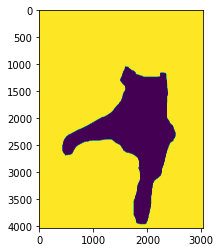

In [182]:
# Load mask where lower resolution patches will be placed

img_mask = img.imread('mask_cat.png')
img_mask[img_mask!=1] = 0
img_mask = img_mask[:,:,0]

plt.imshow(img_mask)
plt.show()

In [183]:
mask_high_resolution = img_mask.astype(bool)
mask_low_resolution = ~img_mask.astype(bool)

In [192]:
area_specific_thresholds = [
    (mask_low_resolution,  500, 30),  # Higher thresholds for area 1
    (mask_high_resolution, 500, 30),  # Lower thresholds for area 2
]

In [175]:
# Prepare the image for processing
unique_colors, label_image = prepare_to_apply_small_patch_rule(image)

In [202]:
# Apply the small patch rule with area-specific thresholds
# Apply it several times to make sure we don't miss any small area

from PIL import Image

image = image_np.copy()

for i in range(5):
    print(f"Round {i+1}:")
    image = apply_small_patch_rule(image, unique_colors, label_image, area_specific_thresholds)
    
    # Save or display the result_image as needed
    # For example, using PIL to save the image
    output_image = Image.fromarray(image)
    output_image.save(f'result_image_round_{i+1}.png')
    
result_image = image.copy()

Round 1:
Covered colours: 0 (193 features),  1 (137 features),  2 (340 features),  3 (507 features),  4 (738 features),  5 (712 features),  6 (47 features),  7 (627 features),  8 (347 features),  9 (241 features),  10 (30 features),  11 (645 features),  12 (436 features),  13 (678 features),  14 (34 features),  15 (164 features),  16 (456 features),  17 (485 features),  18 (29 features),  19 (144 features),  20 (406 features),  21 (80 features),  22 (168 features),  23 (199 features),  24 (5 features),  
Round 2:
Covered colours: 0 (71 features),  1 (32 features),  2 (121 features),  3 (184 features),  4 (251 features),  5 (205 features),  6 (30 features),  7 (160 features),  8 (93 features),  9 (78 features),  10 (17 features),  11 (189 features),  12 (90 features),  13 (188 features),  14 (17 features),  15 (60 features),  16 (113 features),  17 (104 features),  18 (11 features),  19 (54 features),  20 (93 features),  21 (25 features),  22 (31 features),  23 (30 features),  24 (5 fea

In [203]:
# Test patch size

for idx, color in enumerate(unique_colors[:]):
    # Initialize an empty array for the mask (same size as input image, single channel)
    mask = np.all(image == color, axis=-1).astype(np.uint8)

    # Create a binary structure for connectivity
    struct = generate_binary_structure(2, 0)

    # Step 3: Label connected regions
    labeled, num_features = label(mask, structure=struct)
    properties = regionprops(labeled)       

    properties_sorted_by_area = sorted(properties, key=(lambda x:x.area), reverse=True)

    for prop in properties_sorted_by_area:
        # Determine the thresholds to use based on the area
        min_size = None
        min_thickness = None
        for area_mask, area_min_size, area_min_thickness in area_specific_thresholds:
            if area_mask[prop.coords[0, 0], prop.coords[0, 1]]:
                min_size = area_min_size
                min_thickness = area_min_thickness
                break
        if min_size is None or min_thickness is None:
            # Default thresholds if no area-specific thresholds are found
            min_size = 50
            min_thickness = 3

        if prop.area < min_size or min(prop.image.shape) < min_thickness:
            print(f'prop.area = {prop.area}, prop.image.shape = {prop.image.shape}', end='\t')
            print('colour:', image[labeled==prop.label][0])
            
            break
    #print(idx, end=' ')

prop.area = 450, prop.image.shape = (42, 34)	colour: [111  92  72]


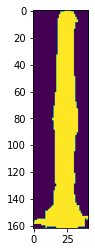

In [204]:
plt.imshow(prop.image)

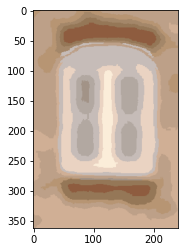

In [359]:
n = 100

min_row, min_col, max_row, max_col = prop.bbox
neighborhood = image[max(min_row-n, 0):min(max_row+n, image.shape[0]),
                     max(min_col-n, 0):min(max_col+n, image.shape[1])]

plt.imshow(neighborhood)

#set minor axes in between the labels
#ax=plt.gca()
#ax.set_xticks([x-0.5 for x in range(1,neighborhood.shape[1])],minor=True )
#ax.set_yticks([y-0.5 for y in range(1,neighborhood.shape[0])],minor=True)
#plot grid on minor axes
#plt.grid(which="minor",ls="-",lw=2, c='w')

plt.show()

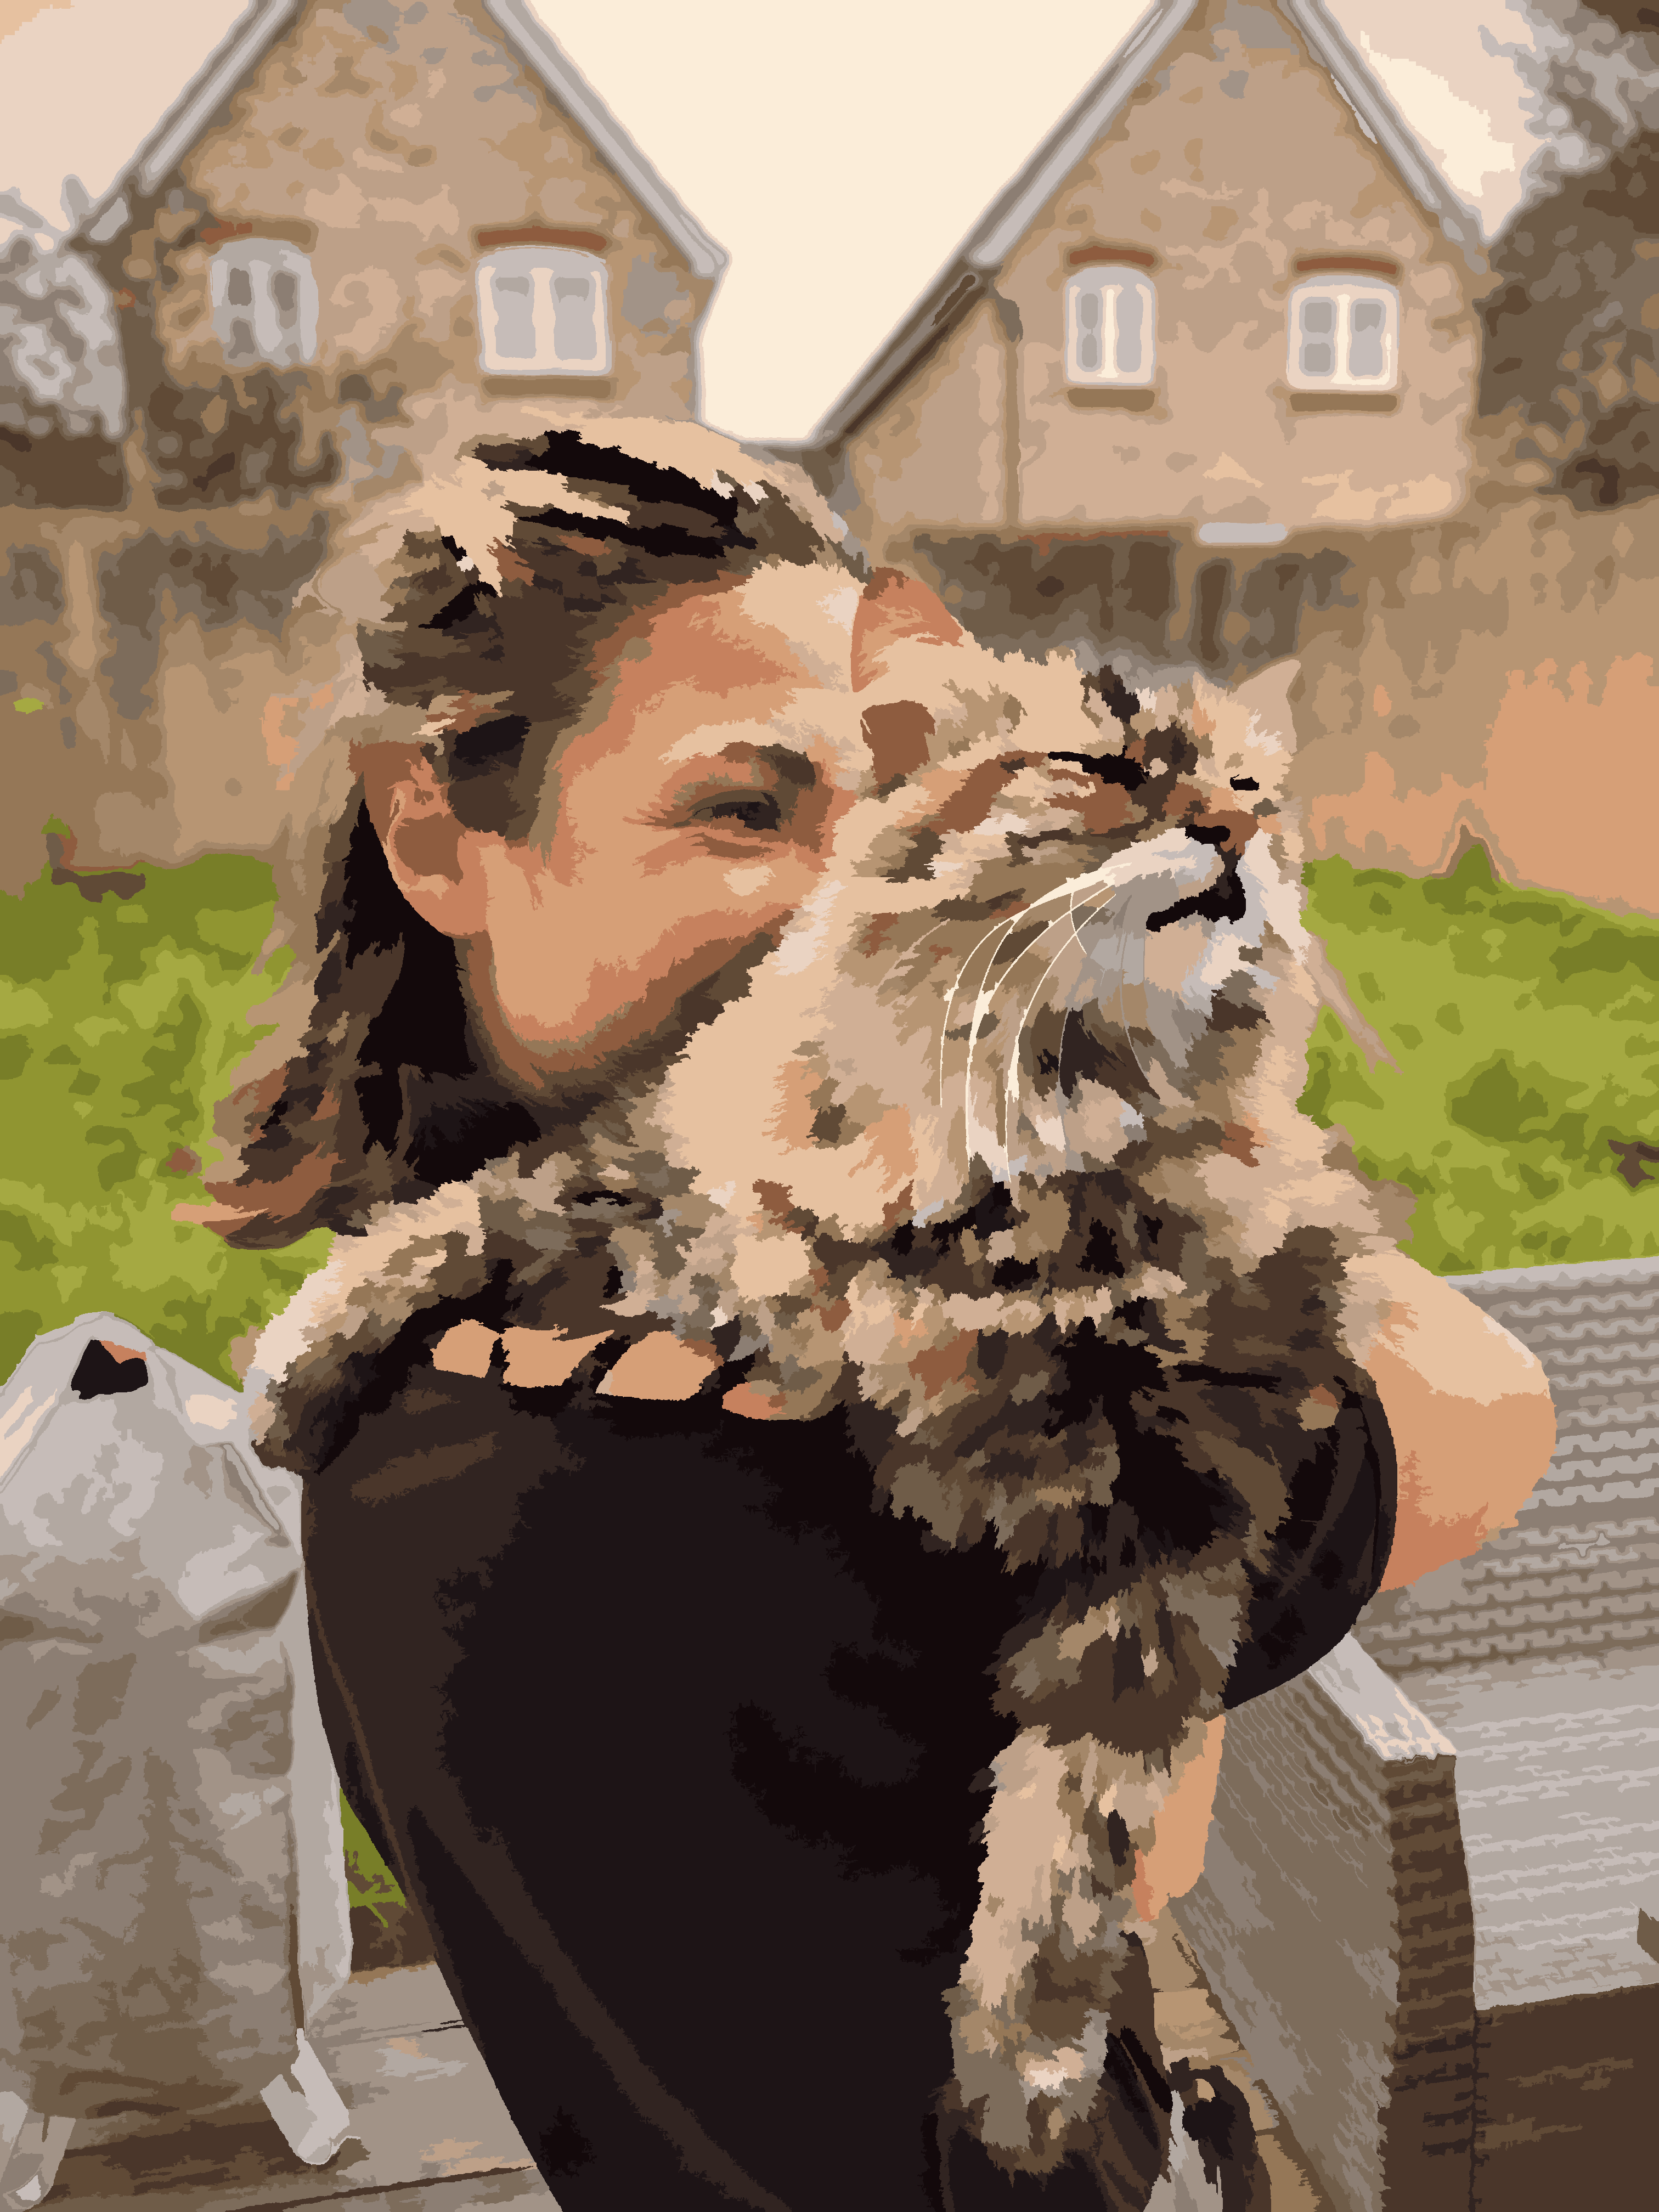

In [205]:
result_image = Image.fromarray(image)
result_image

In [236]:
result_image.save('result_image_rough.png')

_______________

# 07 Sep 2024

I finally managed to smooth out the edges between patches!

In [222]:
import numpy as np
import cv2

def smooth_patch_borders(image, unique_colors, iterations=3):
    """
    Smooth the borders of each patch in a quantized color image using morphological operations.

    Parameters:
    - image: The input color-quantized image (H, W, 3).
    - unique_colors: A list of the unique colors in the quantized image.
    - iterations: Number of iterations for morphological operations to smooth the borders.

    Returns:
    - smoothed_image: The image with smoother patch borders while preserving the quantized colors.
    """
    # Initialize the smoothed image
    smoothed_image = np.zeros_like(image)

    # Process each unique color separately
    for color in unique_colors:
        # Create a binary mask for the current color
        mask = np.all(image == color, axis=-1).astype(np.uint8)

        # Step 1: Dilate the mask to expand the region slightly
        dilated_mask = cv2.dilate(mask, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=iterations)

        # Step 2: Erode the dilated mask to contract it back to the original size, smoothing the edges
        smoothed_mask = cv2.erode(dilated_mask, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=iterations)

        # Apply the smoothed mask to the output image
        smoothed_image[smoothed_mask == 1] = color

    return smoothed_image

In [232]:
image = result_image.copy()

Image.fromarray(image).save(f"smoothed_patch_borders_0_iterations.png")

In [233]:
for iterations in range(1,10):
    # Smooth the borders of each patch
    smoothed_image = smooth_patch_borders(image, unique_colors, iterations=iterations)
    smoothed_im = Image.fromarray(smoothed_image)

    # Save the smoothed image (optional)
    smoothed_im.save(f"smoothed_patch_borders_{iterations}_iterations.png")

In [237]:
# Chose 5
iterations = 5

smoothed_image = smooth_patch_borders(image, unique_colors, iterations=iterations)

smoothed_im = Image.fromarray(smoothed_image)
smoothed_im.save('result_image_smooth.png')

_______________

# Mark contours

25 Aug 2024 - I finally have non-duplicated contours!

In [12]:
from PIL import Image

result_image = np.asarray(Image.open("result_image_smooth.png"))

In [13]:
image = result_image.copy()

In [240]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from tqdm import tqdm

In [241]:
def detect_quantized_color_borders(image):
    """
    Detects borders between color patches in a quantized color image.

    Parameters:
    - image: The input color-quantized image (H, W, 3).

    Returns:
    - contours: List of detected contours representing color borders.
    - contour_image: Image with contours drawn on a black background.
    """

    # Step 1: Create an empty binary edge map
    edges = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

    # Step 2: Compare each pixel with its right and bottom neighbors
    for y in tqdm(range(image.shape[0] - 1)):
        for x in range(image.shape[1] - 1):
            # Compare with the pixel to the right
            if not np.array_equal(image[y, x], image[y, x + 1]):
                edges[y, x] = 255
            # Compare with the pixel below
            if not np.array_equal(image[y, x], image[y + 1, x]):
                edges[y, x] = 255

    # Also handle the last row and column separately
    edges[-1, :] = np.where(np.any(image[-1, :] != image[-2, :], axis=-1), 255, edges[-1, :])
    edges[:, -1] = np.where(np.any(image[:, -1] != image[:, -2], axis=-1), 255, edges[:, -1])

    # Step 3: Find contours on the binary edge map
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    return contours

In [242]:
# Detect borders between color patches
contours = detect_quantized_color_borders(image)

100%|██████████| 4031/4031 [01:12<00:00, 55.69it/s]


In [243]:
# reate a blank image to draw contours on
contour_image = np.ones_like(image)*255

# Draw the contours on the blank image
cv2.drawContours(contour_image, contours, -1, (0, 0, 0), thickness=1)  

# Save the image with detected borders (optional)
cv2.imwrite("contours.png", contour_image)

True

In [ ]:
plt.figure(figsize=(30,40))

for c in contours[:]:
    c2 = np.array(list(c)+[c[0]])
    plt.plot(c2[:,0,0], -c2[:,0,1], '-', lw=1)
    
plt.savefig('all_contours.svg')
plt.savefig('all_contours.pdf')
plt.show()

______________________


# 07 Sep 2024

The next things are to:

1. Decide on the final sizes of the smallest patches, print to test it, and produce the image accordingly

2. Place labels accordingly


With placing labels, I'm having an odd error where a polygon can't be tested to contain another. See below.

**Everything below is an experiment.**

_______________

# Placing labels

Now I want to determine where to place the labels. One way to do this is by calculating where in the polygon representing each patch the largest circle can be contained, also called the pole of inaccessibility. That's the spot where there will be the most room for the label.

One tricky gotcha: neighbour facets can lay completely inside other facets and can overlap the label if only the outer border of the facet is taken in account.

This can be solved by adding the neighbours facet polygon that fall within the facet as additional polygon rings. Then, the `polylabel` function finds the pole of inaccessibility within a polygon. This is the point that is the furthest distance from any edge of the polygon, making it the most spacious location for placing a label.

In [ ]:
import numpy as np
import cv2
from shapely.geometry.polygon import Polygon
from shapely.ops import unary_union, polylabel
from shapely.validation import make_valid
from tqdm import tqdm

In [ ]:
def prepare_to_apply_small_patch_rule(im):
    image = im.copy()
    # Step 1: Create a single-channel label image where each unique color is assigned a unique label
    unique_colors, label_image = np.unique(image.reshape(-1, image.shape[-1]), axis=0, return_inverse=True)
    label_image = label_image.reshape(image.shape[:2])
    return unique_colors, label_image

In [ ]:
from PIL import Image

result_image = np.asarray(Image.open("result_image_smooth.png"))

image = result_image.copy()

unique_colors, label_image = prepare_to_apply_small_patch_rule(image)

In [163]:
def convert_patch_to_polygon(prop):
    
    patch_mask = prop.image
    
    # Find contours of the binary mask
    contours, _ = cv2.findContours(patch_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    
    # Convert the largest contour to a Shapely Polygon
    contour = contours[0].squeeze()
    if contour.ndim != 2 or contour.shape[0] < 3:
        return None  # Invalid contour

    minx, miny = prop.bbox[0], prop.bbox[1]
    contour[:,1] += minx
    contour[:,0] += miny
    
    return Polygon(contour)

In [345]:
def label_patches(im, unique_colors, label_image):
    """
    Process each patch in the image to find the optimal label position using Polylabel.

    Parameters:
    - image: The input color-quantized image (H, W, 3).
    - patch_masks: A list of binary masks, one for each patch.

    Returns:
    - label_positions: A list of optimal label positions for each patch.
    """
    label_positions = []
    labels = []
    polygons = []

    image = im.copy()

    # Step 1: Convert each patch to a Shapely Polygon
    
    print('Covered colours:', end=' ')
    
    for idx, color in enumerate(unique_colors):
        # Initialize an empty array for the mask (same size as input image, single channel)
        mask = np.all(image == color, axis=-1).astype(np.uint8)

        # Create a binary structure for connectivity
        struct = generate_binary_structure(2, 0)
        
        # Step 3: Label connected regions
        labeled, num_features = label(mask, structure=struct)
        properties = regionprops(labeled)       

        properties_sorted_by_area = sorted(properties, key=(lambda x:x.area), reverse=True)
        
        for prop in properties_sorted_by_area:
            polygon = convert_patch_to_polygon(prop)
            if polygon:
                polygons.append(polygon)   
                labels.append(idx)
            
        print(f'{idx} ({num_features} features), ', end=' ')     

    print('Calculating poles of inaccessibility (label positions)')
    
     # Step 2: Calculate the pole of inaccessibility for each polygon
    for i, polygon in tqdm(enumerate(polygons), total=len(polygons)):
        # Find neighboring polygons that are fully inside the current polygon
        inner_neighbors = [poly for j, poly in enumerate(polygons) if i != j and polygon.contains(poly)]

        # Merge inner neighbors as holes in the current polygon
        if inner_neighbors:
            merged_polygon = Polygon(polygon.exterior, [neighbor.exterior for neighbor in inner_neighbors])
        else:
            merged_polygon = polygon

        if not merged_polygon.is_valid:
            merged_polygon = make_valid(merged_polygon)

        while type(merged_polygon) is not Polygon:
            # select largest sub polygon
            areas = [ p.area for p in merged_polygon.geoms ]
            merged_polygon = merged_polygon.geoms[np.argmax(areas)]

        # Calculate the pole of inaccessibility for the merged polygon
        label_position = polylabel(merged_polygon, tolerance=0.5)

        label_positions.append(label_position)   
    
    return label_positions, labels

In [346]:
# Process patches to find optimal label positions

label_positions, labels = label_patches(image, unique_colors, label_image)

Covered colours: 0 (56 features),  1 (32 features),  2 (93 features),  3 (119 features),  4 (133 features),  5 (128 features),  6 (33 features),  7 (142 features),  8 (80 features),  9 (46 features),  10 (17 features),  11 (110 features),  12 (97 features),  13 (121 features),  14 (16 features),  15 (64 features),  16 (94 features),  17 (83 features),  18 (17 features),  19 (44 features),  20 (87 features),  21 (37 features),  22 (28 features),  23 (33 features),  24 (5 features),  Calculating poles of inaccessibility (label positions)


100%|██████████| 1617/1617 [00:44<00:00, 36.58it/s]


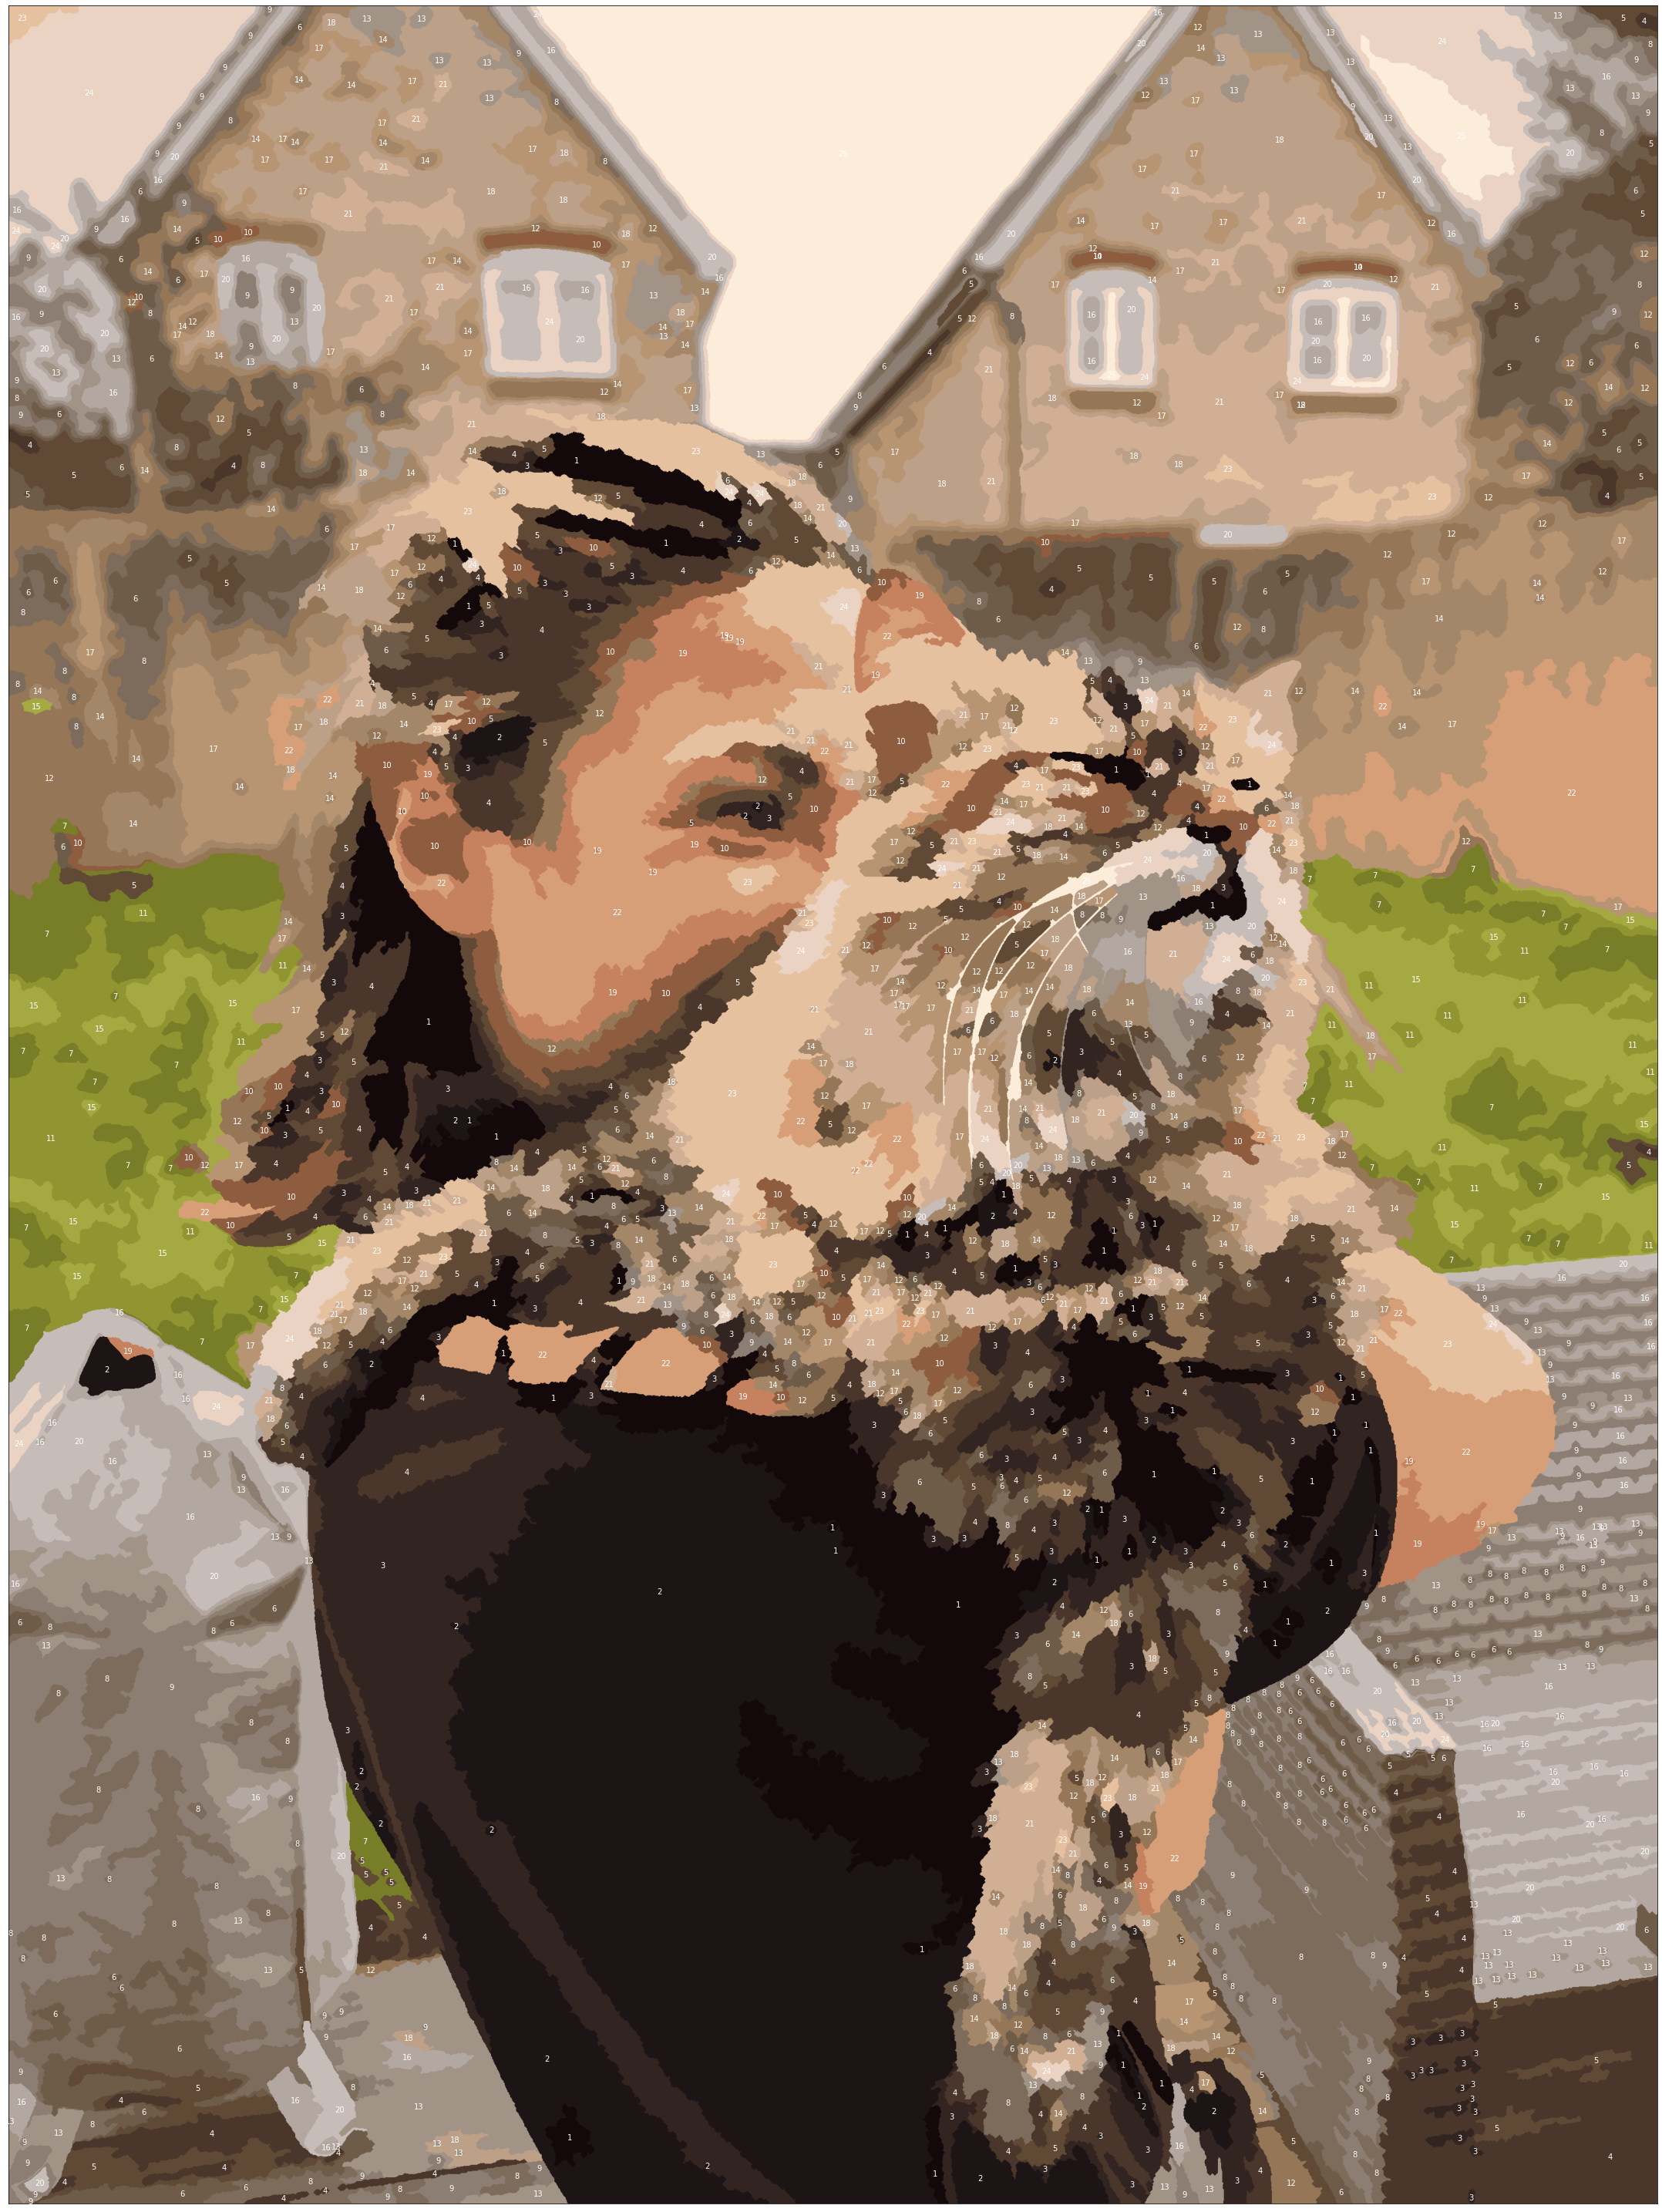

In [488]:
# Visualize the label positions

import matplotlib.pyplot as plt

plt.figure(figsize=(30,40))

plt.imshow(image)

for pos,label in zip(label_positions[:], labels[:]):
    plt.text(pos.x, pos.y, str(label+1), color='white',
             fontsize=10, horizontalalignment='center', verticalalignment='center')
    
plt.yticks([])
plt.xticks([])
plt.tight_layout()

plt.savefig('image_with_labels.png', dpi=200, facecolor='w')
plt.savefig('image_with_labels.pdf', dpi=200)
plt.show()

In [353]:
contour_image = np.asarray(Image.open("contours.png"))

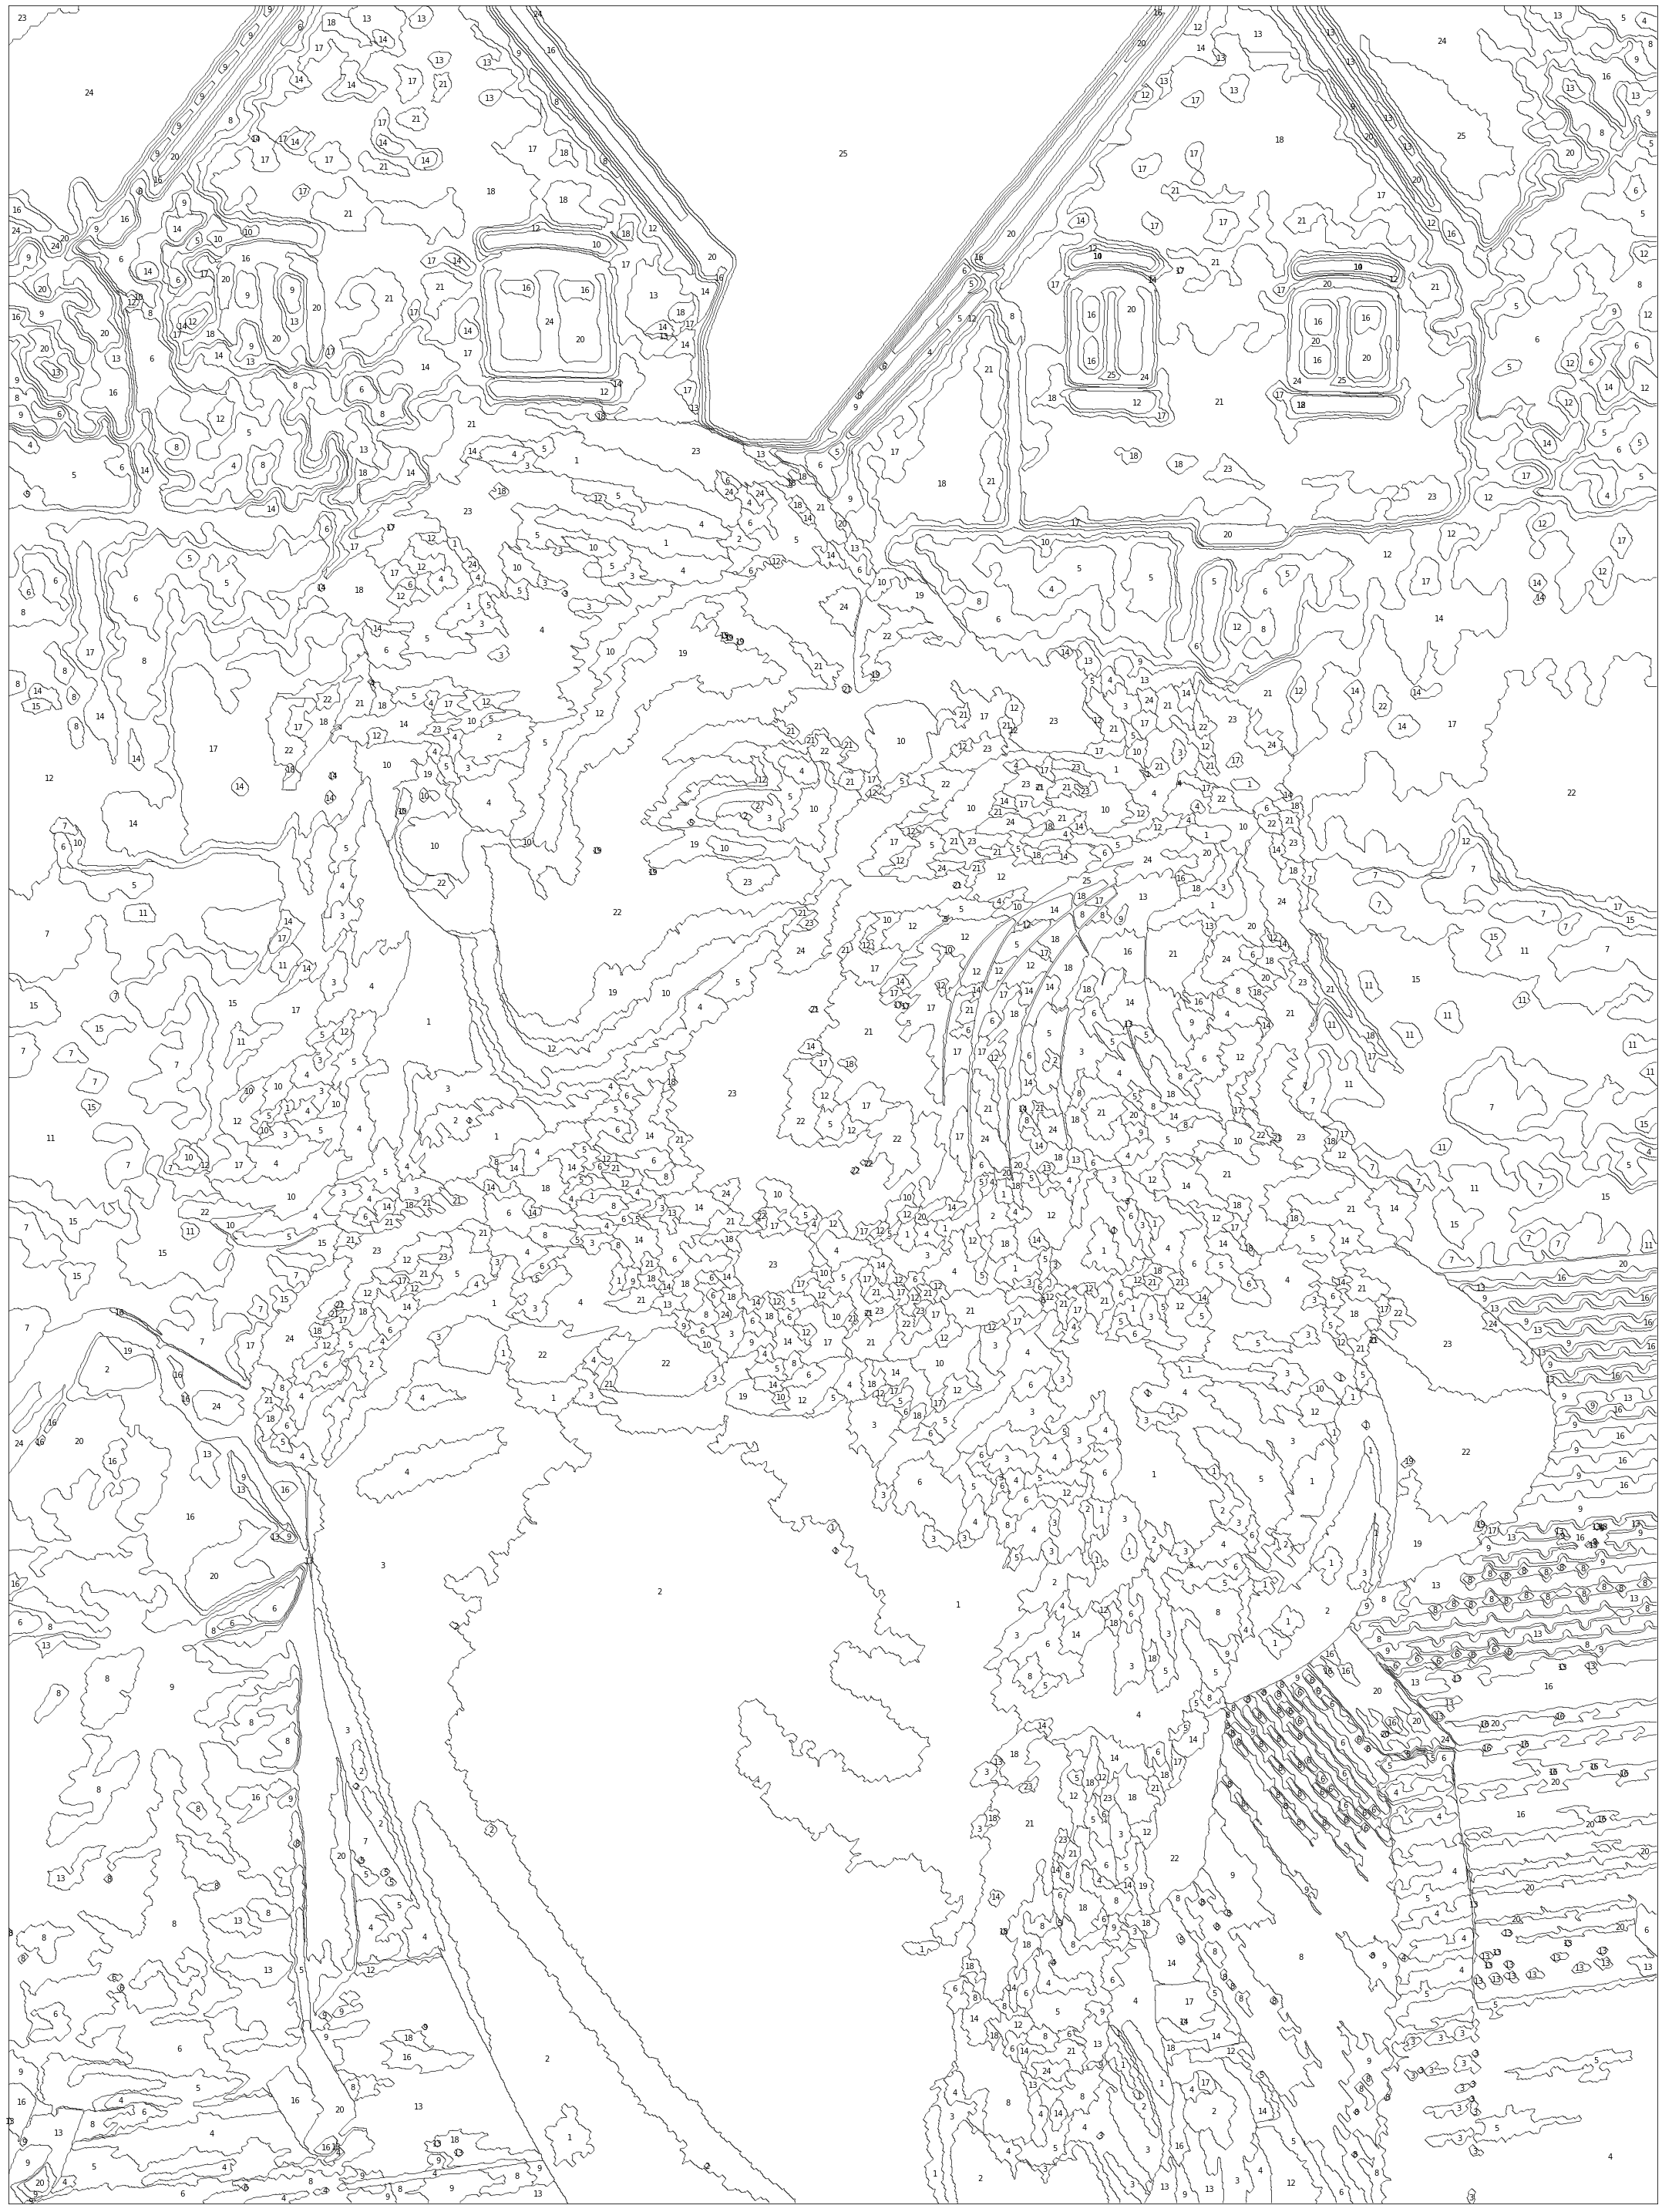

In [487]:
# Visualize the label positions

import matplotlib.pyplot as plt

plt.figure(figsize=(30,40))

plt.imshow(contour_image)

for pos,label in zip(label_positions[:], labels[:]):
    plt.text(pos.x, pos.y, str(label+1), color='k',
             fontsize=10, horizontalalignment='center', verticalalignment='center')

plt.yticks([])
plt.xticks([])
plt.tight_layout()

plt.savefig('contours_with_labels.png', dpi=200, facecolor='w')
plt.savefig('contours_with_labels.pdf', dpi=200)
plt.show()

______________________

# I am happy with this result.

Now the plan is:

1. Print the image in high resolution, on good paper, on two large sheets: one A3, and one A2
2. [DONE] Save some kind of guide: a PDF with the contours, maybe each layer. Save and print that too
3. [DONE] Print the colour list

__________________________

In [ ]:
# Save each layer to a separate file, in case it's interesting

for which, color in enumerate(unique_colors):

    mask = np.all(image == color, axis=-1).astype(np.uint8)

    M = np.ones((mask.shape[0],mask.shape[1],3)).astype(np.uint8)*255
    M[mask!=0] = color
    
    plt.figure(figsize=(15,20))
    plt.imshow(contour_image)
    
    b_channel, g_channel, r_channel = cv2.split(M)
    alpha_channel = (b_channel!=255).astype(np.uint8)*255
    M = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
    plt.imshow(M)
    
    plt.text(0.5*image.shape[1], 120, (which+1), color='k',
                 fontsize=30, horizontalalignment='center', verticalalignment='center')   
    
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout()

    image_path = 'layers_%.2d.pdf' % (which+1)
    plt.savefig(image_path, dpi=150)
    plt.show()

________________

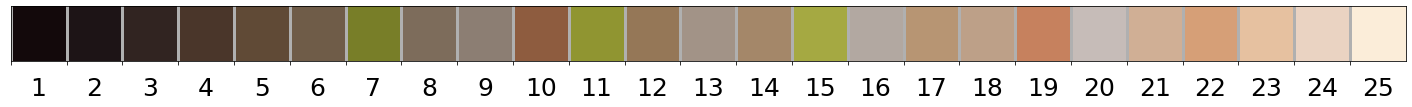

In [476]:
import seaborn as sns
c = unique_colors.copy()/255
sns.palplot(c)

for i in range(len(unique_colors)):
    pos_x = i
    pos_y = 1
    plt.text(pos_x, pos_y, str(i+1), color='k',
             fontsize=25, horizontalalignment='center', verticalalignment='center')
plt.grid('w', lw=3)

plt.show()

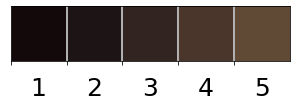

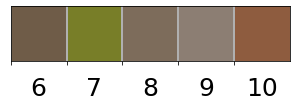

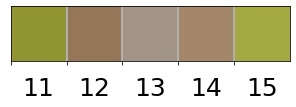

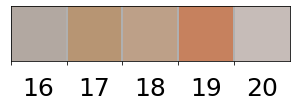

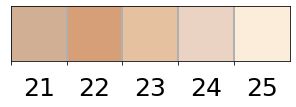

In [475]:
import seaborn as sns

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

c = unique_colors.copy()/255

for i, group in enumerate(chunker(c, 5)):
    sns.palplot(group)
    for j in range(len(group)):
        pos_x = j
        pos_y = 1
        k = i*5 + j+1
        plt.text(pos_x, pos_y, str(k), color='k',
                 fontsize=25, horizontalalignment='center', verticalalignment='center')    
    plt.grid('w', lw=2)
    plt.show()